# Подготовка

Импортируем модули

In [14]:
%matplotlib inline

import random
import os
import cv2

import torch
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

Проверим версии импортированных пакетов, посмотрим на параметры GPU

In [15]:
print(f'torch.__version__ = {torch.__version__}')
print(f'torchvision.__version__ = {torchvision.__version__}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device} \n')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'{gpu_info}')

torch.__version__ = 2.3.1+cu121
torchvision.__version__ = 0.18.1+cu121
device = cuda 

Tue Aug  6 12:40:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |     

Зафиксируем seed для воспроизводимости

In [13]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

seed_everything(42)

Подготовим даталоадер для обучающего и тестового датасета. В качестве датасета будем использовать CIFAR10

In [19]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

# Специальный класс Dataset CIFAR10 для использования с библиотекой Albumentations
class Cifar10AlbumentationsDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label


def load(transform_train, transform_val, batch_size=64, dataset=torchvision.datasets.CIFAR10):
    # Training dataset and loader
    training_set = dataset('./cifar10', train=True, transform=transform_train, download=True)
    training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

    # Test dataset and loader
    validation_set = dataset('./cifar10', train=False, transform=transform_val, download=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)


    # Report split sizes
    print('Training set has {} instances'.format(len(training_set)))
    print('Validation set has {} instances'.format(len(validation_set)))

    return training_loader, validation_loader


Функция для визуализация одного батча

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_batch(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Create a grid from the images and show them
    img_grid = torchvision.utils.make_grid(images)
    matplotlib_imshow(img_grid, one_channel=False)

Инициализируем модель, функцию потерь и оптимизатор

In [18]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


Опишем цикл обучения

In [20]:
def train(model, trainloader, criterion, optimizer):

    model.train()

    fc_gradients = []

    for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if step % 100 == 0:
          print(f'Step: {step}, Loss: {loss}')

        fc_gradients.append(model.fc.weight.grad.mean().item())

Опишем цикл валидации

In [21]:
def test(model, dataloader):
  model.eval()

  with torch.no_grad():
    correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    accuracy = correct/len(dataloader.dataset)

    return accuracy

# Эксперименты

## Torchvision. Попытка №1

Без аугментаций  
Нормализация - (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


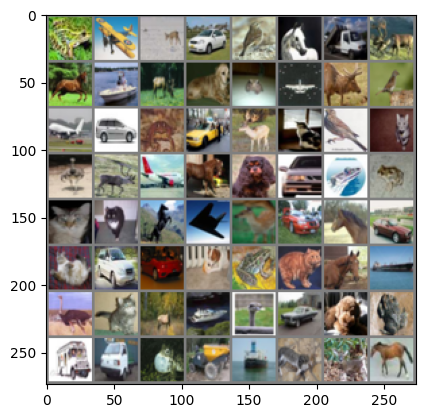

In [ ]:
# Опишем требуемые трансформации
transform_train = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_val = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64)

# Посмотрим на примеры картинок
show_batch(training_loader)


In [ ]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\nTest accuracy = {accuracy}')

Training...


  0%|          | 1/782 [00:00<01:39,  7.86it/s]

Step: 0, Loss: 0.10440294444561005


 14%|█▎        | 106/782 [00:03<00:23, 28.54it/s]

Step: 100, Loss: 0.0715862587094307


 26%|██▋       | 206/782 [00:07<00:20, 28.48it/s]

Step: 200, Loss: 0.06326013803482056


 39%|███▉      | 304/782 [00:11<00:25, 18.86it/s]

Step: 300, Loss: 0.15188764035701752


 52%|█████▏    | 405/782 [00:15<00:12, 29.20it/s]

Step: 400, Loss: 0.12552925944328308


 64%|██████▍   | 503/782 [00:19<00:12, 22.04it/s]

Step: 500, Loss: 0.3059541881084442


 77%|███████▋  | 603/782 [00:23<00:06, 27.41it/s]

Step: 600, Loss: 0.10079115629196167


 90%|█████████ | 706/782 [00:27<00:02, 27.19it/s]

Step: 700, Loss: 0.11279889196157455


100%|██████████| 782/782 [00:30<00:00, 25.69it/s]


Validation...


100%|██████████| 157/157 [00:04<00:00, 36.42it/s]


Test accuracy = 0.7862


## Torchvision. Попытка №2

Без аугментаций  
Нормализация - (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

Files already downloaded and verified
Files already downloaded and verified


Training set has 50000 instances
Validation set has 10000 instances


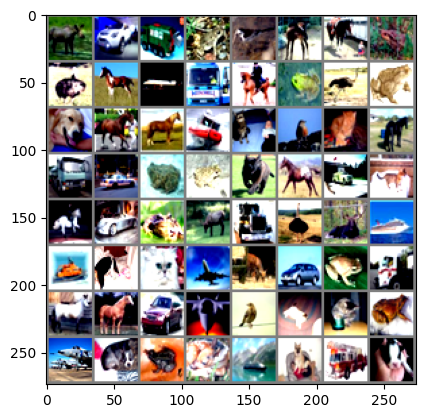

In [ ]:
# Опишем требуемые трансформации
transform_train = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

transform_val = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [ ]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 2/782 [00:00<00:39, 19.68it/s]

Step: 0, Loss: 0.11506737023591995


 13%|█▎        | 104/782 [00:03<00:23, 28.63it/s]

Step: 100, Loss: 0.03872695937752724


 26%|██▋       | 206/782 [00:07<00:20, 28.01it/s]

Step: 200, Loss: 0.14601491391658783


 39%|███▉      | 305/782 [00:11<00:16, 28.83it/s]

Step: 300, Loss: 0.1581343114376068


 52%|█████▏    | 403/782 [00:14<00:13, 28.97it/s]

Step: 400, Loss: 0.13986742496490479


 64%|██████▍   | 503/782 [00:18<00:12, 22.32it/s]

Step: 500, Loss: 0.2222796082496643


 77%|███████▋  | 606/782 [00:22<00:06, 28.65it/s]

Step: 600, Loss: 0.038882046937942505


 90%|█████████ | 705/782 [00:26<00:02, 26.87it/s]

Step: 700, Loss: 0.06276160478591919


100%|██████████| 782/782 [00:28<00:00, 26.98it/s]


Validation...


100%|██████████| 157/157 [00:04<00:00, 38.78it/s]



Test accuracy = 0.6912


## Torchvision. Попытка №3

Попробуем применить аугментации из этого примера:  
https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


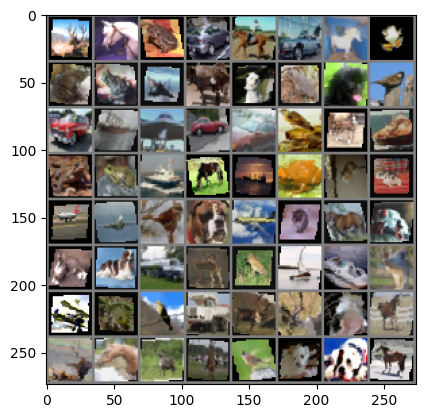

In [ ]:
# Опишем требуемые трансформации
transform_train = transforms.Compose(
    [transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
     transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
     transforms.RandomRotation(10),     #Rotates the image to a specified angel
     transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
     transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
    ])

transform_val = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [ ]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 2/782 [00:00<01:08, 11.42it/s]

Step: 0, Loss: 1.954383373260498


 13%|█▎        | 103/782 [00:09<00:56, 12.08it/s]

Step: 100, Loss: 0.9247931838035583


 26%|██▌       | 203/782 [00:20<00:52, 11.04it/s]

Step: 200, Loss: 0.5576171875


 39%|███▊      | 302/782 [00:28<00:56,  8.57it/s]

Step: 300, Loss: 0.9683420658111572


 51%|█████▏    | 402/782 [00:37<00:32, 11.86it/s]

Step: 400, Loss: 0.6697128415107727


 64%|██████▍   | 502/782 [00:47<00:23, 12.10it/s]

Step: 500, Loss: 0.663518488407135


 77%|███████▋  | 602/782 [00:56<00:15, 11.94it/s]

Step: 600, Loss: 0.656173825263977


 90%|████████▉ | 702/782 [01:04<00:07, 10.99it/s]

Step: 700, Loss: 0.6414062976837158


100%|██████████| 782/782 [01:13<00:00, 10.68it/s]


Validation...


100%|██████████| 157/157 [00:04<00:00, 33.25it/s]



Test accuracy = 0.8135


## Torchvision. Попытка №4

Возьмем предыдущий пример и уберем оттуда `RandomAffine` и `ColorJitter`. Оценим как они повлияют на точность.

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


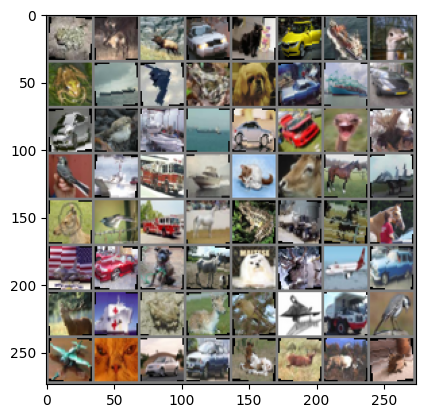

In [ ]:
# Опишем требуемые трансформации
transform_train = transforms.Compose(
    [transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
     transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
     transforms.RandomRotation(10),     #Rotates the image to a specified angel
     #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
     #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
     transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
    ])

transform_val = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [ ]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 2/782 [00:00<00:47, 16.27it/s]

Step: 0, Loss: 0.33408764004707336


 13%|█▎        | 105/782 [00:05<00:34, 19.88it/s]

Step: 100, Loss: 0.3746775686740875


 26%|██▌       | 204/782 [00:10<00:25, 23.08it/s]

Step: 200, Loss: 0.3973514437675476


 39%|███▊      | 303/782 [00:14<00:21, 22.26it/s]

Step: 300, Loss: 0.7072826027870178


 52%|█████▏    | 405/782 [00:19<00:16, 22.22it/s]

Step: 400, Loss: 0.4141468107700348


 64%|██████▍   | 504/782 [00:24<00:12, 22.80it/s]

Step: 500, Loss: 0.3318198025226593


 77%|███████▋  | 603/782 [00:28<00:10, 16.33it/s]

Step: 600, Loss: 0.37932491302490234


 90%|█████████ | 704/782 [00:33<00:03, 21.62it/s]

Step: 700, Loss: 0.5101435780525208


100%|██████████| 782/782 [00:37<00:00, 20.89it/s]


Validation...


100%|██████████| 157/157 [00:03<00:00, 43.38it/s]



Test accuracy = 0.818


## Albumentations. Попытка №1

Возьмем примеры аугментаций отсюда:   
https://albumentations.ai/docs/examples/pytorch_classification/

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


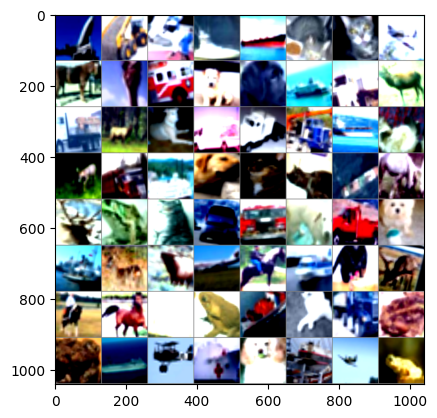

In [29]:
# Опишем требуемые трансформации
transform_train = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

transform_val = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64, dataset=Cifar10AlbumentationsDataset)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [30]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 2/782 [00:00<02:29,  5.22it/s]

Step: 0, Loss: 3.25290584564209


 13%|█▎        | 102/782 [00:15<01:39,  6.85it/s]

Step: 100, Loss: 1.6012299060821533


 26%|██▌       | 202/782 [00:30<01:21,  7.11it/s]

Step: 200, Loss: 1.092415690422058


 39%|███▊      | 302/782 [00:45<01:24,  5.65it/s]

Step: 300, Loss: 0.9720607399940491


 51%|█████▏    | 402/782 [01:00<00:58,  6.47it/s]

Step: 400, Loss: 0.6755161881446838


 64%|██████▍   | 502/782 [01:15<00:39,  7.00it/s]

Step: 500, Loss: 0.7862112522125244


 77%|███████▋  | 602/782 [01:31<00:25,  6.99it/s]

Step: 600, Loss: 0.9077107310295105


 90%|████████▉ | 702/782 [01:46<00:11,  6.87it/s]

Step: 700, Loss: 0.5892794132232666


100%|██████████| 782/782 [01:58<00:00,  6.59it/s]


Validation...


100%|██████████| 157/157 [00:07<00:00, 20.56it/s]



Test accuracy = 0.7595


## Albumentations. Попытка №2

Попробуем сделать нормализацию 0.5

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


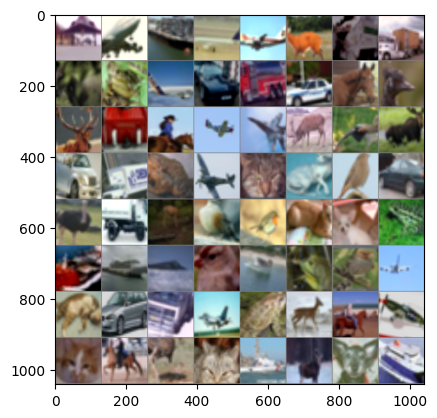

In [31]:
# Опишем требуемые трансформации
transform_train = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

transform_val = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ]
)
# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64, dataset=Cifar10AlbumentationsDataset)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [32]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 1/782 [00:00<02:25,  5.38it/s]

Step: 0, Loss: 0.589744508266449


 13%|█▎        | 102/782 [00:15<01:37,  6.98it/s]

Step: 100, Loss: 0.3329632878303528


 26%|██▌       | 202/782 [00:29<01:21,  7.13it/s]

Step: 200, Loss: 0.5498300790786743


 39%|███▊      | 302/782 [00:44<01:06,  7.17it/s]

Step: 300, Loss: 0.7445787787437439


 51%|█████▏    | 402/782 [00:59<01:05,  5.83it/s]

Step: 400, Loss: 0.7764852643013


 64%|██████▍   | 502/782 [01:15<00:39,  7.10it/s]

Step: 500, Loss: 0.6027495861053467


 77%|███████▋  | 602/782 [01:30<00:26,  6.92it/s]

Step: 600, Loss: 0.60608971118927


 90%|████████▉ | 702/782 [01:44<00:11,  7.13it/s]

Step: 700, Loss: 0.6312347054481506


100%|██████████| 782/782 [01:56<00:00,  6.70it/s]


Validation...


100%|██████████| 157/157 [00:07<00:00, 21.49it/s]



Test accuracy = 0.809


## Albumentations. Попытка №3

Нормализация 0.5 по всем каналам показывает результаты получше. Будем использовать ее и дальше.  
Попробуем уменьшить размер до 32х32 как в примере с torchvision

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


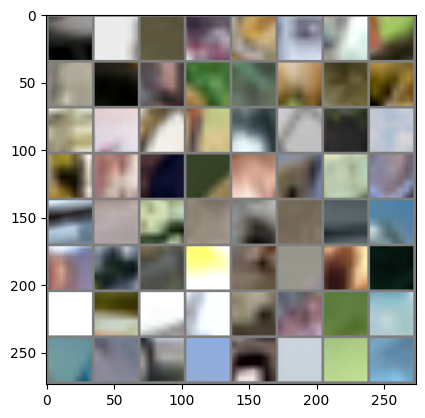

In [33]:
# Опишем требуемые трансформации
transform_train = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=32, width=32),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

transform_val = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=32, width=32),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ]
)
# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64, dataset=Cifar10AlbumentationsDataset)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [34]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 2/782 [00:00<01:07, 11.57it/s]

Step: 0, Loss: 2.983654260635376


 13%|█▎        | 103/782 [00:09<00:55, 12.34it/s]

Step: 100, Loss: 1.954899549484253


 26%|██▌       | 203/782 [00:18<00:45, 12.63it/s]

Step: 200, Loss: 2.0802485942840576


 39%|███▊      | 303/782 [00:26<00:37, 12.70it/s]

Step: 300, Loss: 2.0479989051818848


 52%|█████▏    | 403/782 [00:35<00:31, 12.18it/s]

Step: 400, Loss: 2.1360180377960205


 64%|██████▍   | 502/782 [00:44<00:22, 12.55it/s]

Step: 500, Loss: 2.0597825050354004


 77%|███████▋  | 602/782 [00:52<00:16, 10.97it/s]

Step: 600, Loss: 1.939724326133728


 90%|████████▉ | 703/782 [01:02<00:06, 12.57it/s]

Step: 700, Loss: 2.1182610988616943


100%|██████████| 782/782 [01:09<00:00, 11.29it/s]


Validation...


100%|██████████| 157/157 [00:02<00:00, 54.00it/s]



Test accuracy = 0.3363


## Albumentations. Попытка №4

Что-то кроп до 32х32 показал очень плохой результат.  
Вернем кроп 128х128.   
Попробуем отключить `ShiftScaleRotate`, `RGBShift`, `RandomBrightnessContrast`.

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


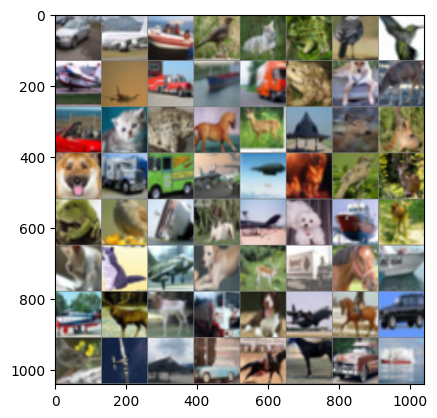

In [46]:
# Опишем требуемые трансформации
transform_train = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

transform_val = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ]
)
# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64, dataset=Cifar10AlbumentationsDataset)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [47]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 1/782 [00:00<01:56,  6.70it/s]

Step: 0, Loss: 1.0041983127593994


 13%|█▎        | 102/782 [00:10<01:08,  9.86it/s]

Step: 100, Loss: 0.5173996090888977


 26%|██▌       | 202/782 [00:22<01:10,  8.27it/s]

Step: 200, Loss: 0.7077805399894714


 39%|███▊      | 302/782 [00:34<00:49,  9.76it/s]

Step: 300, Loss: 0.6128050684928894


 51%|█████▏    | 402/782 [00:46<00:39,  9.66it/s]

Step: 400, Loss: 0.43819987773895264


 64%|██████▍   | 503/782 [00:58<00:28,  9.94it/s]

Step: 500, Loss: 0.49689412117004395


 77%|███████▋  | 602/782 [01:08<00:20,  8.69it/s]

Step: 600, Loss: 0.43996283411979675


 90%|████████▉ | 702/782 [01:18<00:08,  8.95it/s]

Step: 700, Loss: 0.5645604133605957


100%|██████████| 782/782 [01:27<00:00,  8.95it/s]


Validation...


100%|██████████| 157/157 [00:07<00:00, 20.91it/s]



Test accuracy = 0.8542


## Albumentations. Попытка №5

Без аугментаций цвета точность повысилась. Попробуем вернуть `ShiftScaleRotate`

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


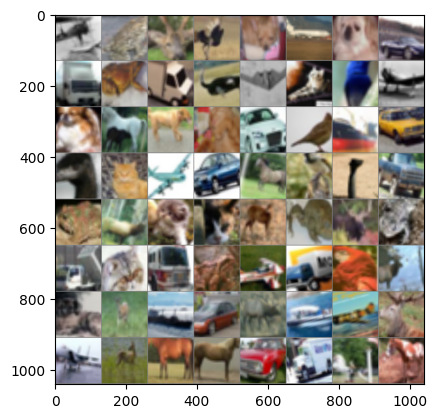

In [48]:
# Опишем требуемые трансформации
transform_train = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

transform_val = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ]
)
# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64, dataset=Cifar10AlbumentationsDataset)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [49]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 1/782 [00:00<02:21,  5.52it/s]

Step: 0, Loss: 0.4445267915725708


 13%|█▎        | 102/782 [00:14<01:29,  7.57it/s]

Step: 100, Loss: 0.2899987995624542


 26%|██▌       | 202/782 [00:27<01:17,  7.52it/s]

Step: 200, Loss: 0.4766979515552521


 38%|███▊      | 301/782 [00:42<01:11,  6.70it/s]

Step: 300, Loss: 0.5143342614173889


 51%|█████▏    | 402/782 [00:58<00:55,  6.87it/s]

Step: 400, Loss: 0.5793858170509338


 64%|██████▍   | 502/782 [01:11<00:44,  6.24it/s]

Step: 500, Loss: 0.36304911971092224


 77%|███████▋  | 602/782 [01:26<00:26,  6.90it/s]

Step: 600, Loss: 0.7127119898796082


 90%|████████▉ | 702/782 [01:42<00:11,  7.07it/s]

Step: 700, Loss: 0.5142481923103333


100%|██████████| 782/782 [01:53<00:00,  6.88it/s]


Validation...


100%|██████████| 157/157 [00:06<00:00, 22.59it/s]



Test accuracy = 0.8674


# Результаты

## Описание эксперимента

Для анализа влияния аугментаций была выбрана задача классификации.   
Для примера из pytorch взяты станартные:
* сеть ResNet18 c дефолтными весами
* функция потеть CrossEntropyLoss
* оптимизатор Adam c дефолтными параметрами
* датасет CIFAR10

Для адаптации CIFAR10 к работе с Albumentations написан кастомный датасет, переопределяющий поведение с трансформациями.

Код цикла обучения, валидации и визуализации датасета используется одинаковый для всех экспериментов.




## Сравнительная таблица

| № | Точность |                                   Комментарий                                   |
|---|----------|---------------------------------------------------------------------------------|
| 1 |   0.7862 | Без аугментаций. Нормализация - (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)                |
| 2 |   0.6912 | Без аугментаций. Нормализация - (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261) |
| 3 |   0.8135 | Разные аугментации torchvision                                                  |
| 4 |    0.818 | Разные аугментации torchvision без RandomAffine и ColorJitter                   |
| 5 |   0.7595 | Albumentations. Разные аугментации                                              |
| 6 |    0.809 | Albumentations. Нормализация 0.5                                                |
| 7 |   0.3363 | Albumentations. Crop 32х32                                                      |
| 8 |   0.8542 | Albumentations. Без ShiftScaleRotate, RGBShift, RandomBrightnessContrast        |
| 9 |   0.8674 | Albumentations. Без RGBShift, RandomBrightnessContrast                          |




## Выводы

1. Нормализация существенно влияет на точность модели. При этом нормализация "везде 0.5" почему-то работает лучше, чем специфические значения.
2. Сrop 32х32 хорошо работает в `torchvision`, но почему-то приводит к ухудщению результатов в `Albumentations`
3. В `torchvision` аугментации `RandomAffine` и `ColorJitter` практически не влияют на результат
4. В `Albumentations` отключение `RGBShift`, `RandomBrightnessContrast` приводит к улучшению результата